<a href="https://colab.research.google.com/github/elaine2233/ICH/blob/main/SGAN_git_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import random
random.seed(12345)

In [ ]:
#librarys
!pip install dicom
# !pip install tensorflow==1.14.0 
import dicom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10,mnist
import numpy as np
import argparse
import cv2
import os
from tensorflow.keras import layers # just randommmmm
import matplotlib.pyplot as plt

     |████████████████████████████████| 766 kB 31.1 MB/s 


/usr/local/lib/python3.7/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Connect to google drive and google cloud

## connect to google drive

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract type y
import pandas as pd
# typey0 = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage2train_wide_unique2.csv')
typey0 = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage2train_wide_posneg.csv')
typey0['ID'] = 'ID_' + typey0['ID2'].astype(str)
typey0['IDpng'] = typey0['ID'].astype(str) + '.png'
typey0 = typey0[typey0.ID != 'ID_6431af929']
typey0[:5]

,Unnamed: 0,ID2,any,ID,IDpng
0,1,000012eaf,0,ID_000012eaf,ID_000012eaf.png
1,2,000039fa0,0,ID_000039fa0,ID_000039fa0.png
2,3,00005679d,0,ID_00005679d,ID_00005679d.png
3,4,00008ce3c,0,ID_00008ce3c,ID_00008ce3c.png
4,5,0000950d7,0,ID_0000950d7,ID_0000950d7.png


In [ ]:
# Patient ID
import pandas as pd
pid = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage_2_train_with_metadata.csv')
typey = pd.merge(typey0,pid,on='ID',how='left')
typey = typey.sort_values('PatientID')
typey[:5]

#calculate patient level sum
UnqPID = pd.DataFrame({'Sum_img':pid.groupby(['PatientID']).size()}).reset_index()
np.random.seed(111111)
UnqPID = UnqPID.sample(frac=1)
UnqPID['Cum_sum'] = UnqPID['Sum_img'].cumsum()
UnqPID[:5],typey[:5]

(         PatientID  Sum_img  Cum_sum
 4725   ID_3faf02aa       32       32
 14762  ID_c760b47b       32       64
 8564   ID_73637515       34       98
 11733  ID_9d84a9b3       48      146
 4012   ID_357d6d92       32      178,
         Unnamed: 0        ID2  any            ID             IDpng    PatientID
 108780      108781  24f7cfc41    0  ID_24f7cfc41  ID_24f7cfc41.png  ID_0002cd41
 3397          3398  012b0d238    0  ID_012b0d238  ID_012b0d238.png  ID_0002cd41
 86943        86944  1d88058ff    0  ID_1d88058ff  ID_1d88058ff.png  ID_0002cd41
 689375      689377  ea722c4e5    0  ID_ea722c4e5  ID_ea722c4e5.png  ID_0002cd41
 81401        81402  1b9de2922    0  ID_1b9de2922  ID_1b9de2922.png  ID_0002cd41)

## connect to google cloud

In [ ]:
# connect to google cloud
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

# Extract Data

In [ ]:
#100 sample
# !gsutil cp gs://chl7001gp_bucket_png_128/imgs.zip . 

#full data
!gsutil cp gs://chl7001gp_bucket_png_128/image_png.zip . 

Copying gs://chl7001gp_bucket_png_128/image_png.zip...
- [1 files][  3.3 GiB/  3.3 GiB]   50.9 MiB/s                                   
Operation completed over 1 objects/3.3 GiB.                                      


In [ ]:
#unzip the first 100 images
# !unzip /content/imgs.zip

In [ ]:
#unzip full data
!unzip /content/image_png.zip

In [ ]:
# retrain for all data
datapath = '/content/kaggle/working/output/stage_2_train'

In [ ]:
import math
def roundup(x):
  return int(math.ceil(x / 100.0)) * 100

In [ ]:
for image in  os.listdir(datapath):
  # path = os.path.join('/content/data',image)
  print(image)
  break

ID_270a84bf1.png


# View Plots

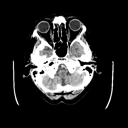

In [ ]:
#view plots in tensorflow
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img("/content/kaggle/working/output/stage_2_train/ID_023f03565.png")
img

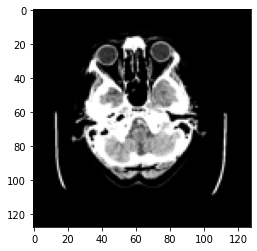

In [ ]:
plt.imshow(img)

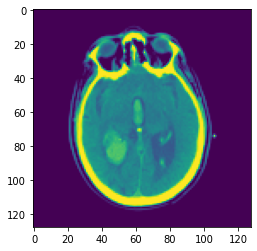

In [ ]:
# plt.imshow(trainX[3])
# plt.imshow(testX[3])

# Image preparation

In [ ]:
datapath = '/content/kaggle/working/output/stage_2_train'


#check length of image
imglist = os.listdir(datapath) # dir is your directory path
number_files = len(imglist)
print(number_files)

752802


In [ ]:
number_y = typey.shape[0]
print(number_y)

752802


In [ ]:
import math
number_y = 720728
ntrain0 = math.ceil(number_y*0.7)

# nsuptrain = roundup(number_y*0.7*0.1)

#select every thing till 70%
trainPID = UnqPID[UnqPID['Cum_sum']<ntrain0]['PatientID'].tolist()

trainy_name = typey[typey['PatientID'].isin(trainPID)]['ID']
testy_name = typey[-typey['PatientID'].isin(trainPID)]['ID']

# trainy = typey[typey['PatientID'].isin(trainPID)]['category2'].tolist()
# testy = typey[-typey['PatientID'].isin(trainPID)]['category2'].tolist()
trainy = typey[typey['PatientID'].isin(trainPID)]['any'].tolist()
testy = typey[-typey['PatientID'].isin(trainPID)]['any'].tolist()
trainy = np.array(trainy)
testy = np.array(testy)

ntrain = trainy_name.shape[0]
nsuptrain = math.ceil(ntrain*0.1)
ntest = testy_name.shape[0]

print(ntrain,ntest, nsuptrain, len(trainy_name),len(testy_name), trainy.shape,testy.shape)

504446 248356 50445 504446 248356 (504446,) (248356,)


In [ ]:
trainy_name[trainy_name == 'ID_6431af929'],testy_name[testy_name == 'ID_6431af929']

(Series([], Name: ID, dtype: object), Series([], Name: ID, dtype: object))

In [ ]:
#check if patient in train is in test
trainuqpid = typey[typey['PatientID'].isin(trainPID)]['PatientID'].unique()
testuqpid = typey[-typey['PatientID'].isin(trainPID)]['PatientID'].unique()

np.intersect1d(trainuqpid,testuqpid)

array([], dtype=object)

In [ ]:
#convert from RBG to grey (because rgb has 3 dimension (the third dimension is color) but this model only have two)
def grayConversion(image):
    grayValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
    gray_img = grayValue.astype(np.uint8)
    return gray_img

In [ ]:
def split_list(a_list, num_to_split):
    prop = num_to_split
    return a_list[:prop], a_list[prop:]


In [ ]:
typey = typey[typey['IDpng'].isin(imglist)]
typey.shape

(752802, 6)

In [ ]:
#first 10000 data
# partn = 10000
# trainy_name = trainy_name[:partn]
# trainy = trainy[:partn]
# number_y = len(trainy_name)
# ntrain = roundup(number_y*0.7)
# nsuptrain = roundup(number_y*0.7*0.1)
# len(trainy_name),trainy.shape,ntrain,nsuptrain

(10000, (10000,), 7000, 700)

In [ ]:
len(trainy_name),trainy.shape

(10000, (10000,))

In [ ]:
trainy_name[:5]

117763    ID_29c8b92d1
636102    ID_e1d7ed00c
239940    ID_550ee1307
622327    ID_dcdfc67c3
706148    ID_fac810a40
Name: ID, dtype: object

In [ ]:
#summary of trainy and testy
from collections import Counter
Counter(trainy),Counter(testy)

(Counter({0: 432334, 1: 72112}), Counter({0: 212535, 1: 35821}))

In [ ]:

# img = cv2.imread(datapath+ '/' + 'ID_6431af929' + '.png')
# img is None

True

# Small Example

In [ ]:
# select real samples
def generate_real_samples(datasety, n_samples):
  trainy_name, labels = datasety
  # choose random instances
  ix = randint(0, len(trainy_name), n_samples)

  # select images and labels
  X = list()
  for id in np.array(trainy_name)[ix]:
    img = cv2.imread(datapath+ '/' + id + '.png')
    img = grayConversion(img)
    X.append(img)
  
  X = np.array(X)
  X = expand_dims(X, axis=-1)
  # print(X.shape)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  print(X.shape)
  labels = labels[ix]

  # generate class labels
  y = ones((n_samples, 1))
  # print(X)
  return [X, labels], y

In [ ]:
datasety = trainy_name, trainy 
[X, labels], y = generate_real_samples(datasety,50)
print(X.shape,labels.shape,y.shape)

(50, 128, 128, 1)
(50, 128, 128, 1) (50,) (50, 1)


In [ ]:
labels[:50]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np 



model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation='relu',input_shape=(128, 128, 1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='softmax'))

model.compile(optimizer='adam',loss='binary_crossentropy')

model.summary()


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 126, 64)      640       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1016064)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1016064)           0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 1016065   
Total params: 1,016,705
Trainable params: 1,016,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.fit(X,labels,batch_size=50, epochs=10)  

Epoch 1/10
1/1 [==============================] - 31s 31s/step - loss: 0.7046
Epoch 2/10
1/1 [==============================] - 0s 35ms/step - loss: 1.9183
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 2.8208
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 3.2012
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 3.2845
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 3.1857
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 2.9575
Epoch 8/10
1/1 [==============================] - 0s 33ms/step - loss: 2.6899
Epoch 9/10
1/1 [==============================] - 0s 34ms/step - loss: 2.3979
Epoch 10/10
1/1 [==============================] - 0s 33ms/step - loss: 2.0776


In [ ]:
# !pip uninstall keras 
# !pip install keras==2.2.4 
# !pip install keras
from keras.models import Sequential
from keras.layers import Conv2D
import tensorflow as tf
# inputs = Input(shape=(784,))  
model = Sequential()
model.add(Conv2D(64, (3,3),strides=(2,2),  padding='same', activation='relu',input_shape=(128, 128, 1)))
# model.add(Conv2D(32, (1,1), activation='relu'))
# model.add(LeakyReLU(alpha=0.1))
model.summary()

# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


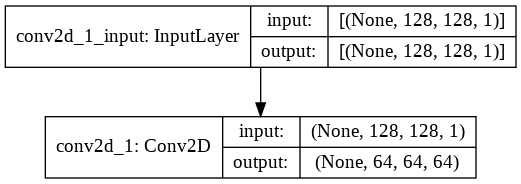

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
def train(model, datasety, n_epochs=20, n_batch=100):
	# y_sup, yname_sup = datasety
  # calculate the number of batches per training epoch
  bat_per_epo = int(ntrain / n_batch)
	# calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
  for i in range(n_steps):
		# update supervised discriminator (c)
    [Xsup_real, ysup_real], _ = generate_real_samples(datasety, half_batch)
    print(Xsup_real.shape, ysup_real.shape)
    c_loss, c_acc = model.train_on_batch(Xsup_real, ysup_real)
		# summarize loss on this batch
    print('>%d, c[%.3f,%.0f]' % (i+1, c_loss, c_acc*100))
		# evaluate the model performance every so often
		# if (i+1) % (bat_per_epo * 1) == 0:
		# 	summarize_performance(i, g_model, c_model, latent_dim, datasety, n_valid=1000)

In [ ]:
datasety = trainy_name, trainy 
train(model,datasety)

# SGAN

In [ ]:
# example of defining semi-supervised discriminator model

# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(128,128,1), n_classes=6):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)

	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
	return d_model, c_model
 


In [ ]:
# create model
d_model, c_model = define_discriminator()

print(d_model.summary(),c_model.summary())

Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 16, 16, 128)       0  

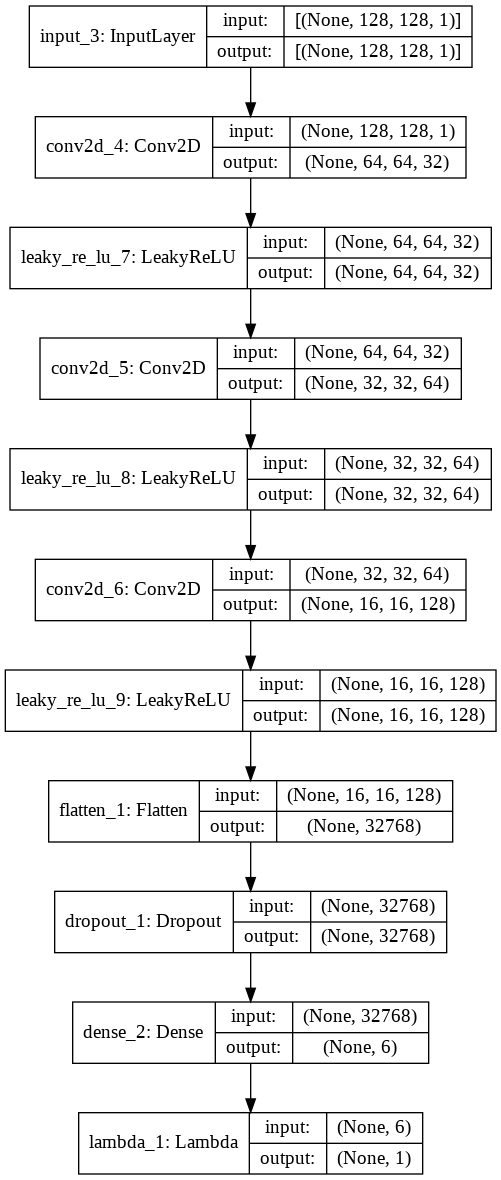

In [ ]:
# plot the model
plot_model(d_model, to_file='stacked_discriminator1_plot.png', show_shapes=True, show_layer_names=True)

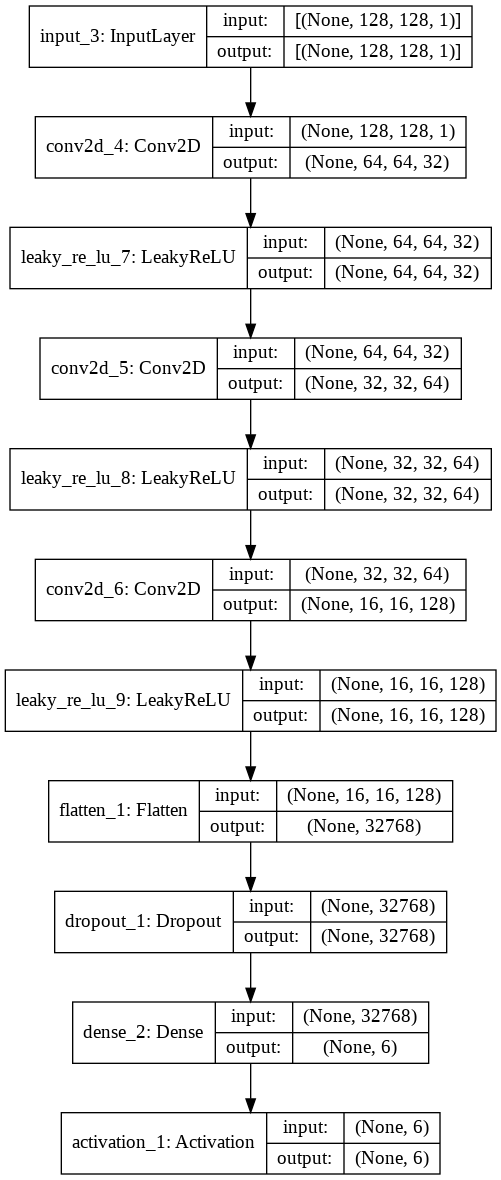

In [ ]:
plot_model(c_model, to_file='stacked_discriminator2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 16x16 image
	n_nodes = 128 * 16 * 16
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((16, 16, 128))(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 	# upsample to 128x128
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)

	# output
	out_layer = Conv2D(1, (16,16), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

In [ ]:
# size of the latent space
latent_dim = 100

# create the generator
g_model = define_generator(latent_dim)


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load the images
def load_real_samples():
  # load dataset
  # (trainX, trainy), (testX, testy) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  print(X.shape)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  # print(X.shape, trainy.shape)
  return [X, trainy]

In [ ]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(datasety, n_samples=nsuptrain, n_classes=6):
  trainy_name, trainy = datasety
  X_list, y_list, yname_list = list(), list(), list()
  n_per_class = int(n_samples / n_classes)
  for iclass in range(n_classes):
    
    # get all images ID for this class
    idindex = [i for i, e in enumerate(trainy) if e == iclass]
    idname = np.array(trainy_name)[idindex]

    # choose random instances
    ix = randint(0, len(idname), n_per_class)

    # add to list
    for id in idname[ix]:
      img = cv2.imread(datapath+ '/' + id + '.png')
      img = grayConversion(img)
      X_list.append(img)
      yname_list.append(id)
    
    [y_list.append(iclass) for j in ix]
  return asarray(X_list), asarray(y_list), asarray(yname_list)

In [ ]:
datasety = trainy_name, trainy 
X_sup, y_sup, yname_sup = select_supervised_samples(datasety)

In [ ]:
# y_sup.shape,yname_sup.shape,Counter(trainy),Counter(y_sup)

((50496,),
 (50496,),
 Counter({0: 451508, 1: 1209, 2: 10942, 3: 6915, 4: 11490, 5: 22536}),
 Counter({0: 8416, 1: 8416, 2: 8416, 3: 8416, 4: 8416, 5: 8416}))

In [ ]:
# select real samples
def generate_real_samples(datasety, n_samples):
  trainy_name, labels = datasety
  # choose random instances
  ix = randint(0, len(trainy_name), n_samples)

  # select images and labels
  X = list()
  for id in np.array(trainy_name)[ix]:
    img = cv2.imread(datapath+ '/' + id + '.png')
    img = grayConversion(img)
    X.append(img)
  
  X = np.array(X)
  labels = labels[ix]

  # generate class labels
  y = ones((n_samples, 1))
  # print(X)
  return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, datasety, n_valid, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model (validation)
	[X, _], y = generate_real_samples(datasety,n_valid)
  # X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, datasety, latent_dim, n_epochs=20, n_batch=100):
	# select supervised dataset
	X_sup, y_sup, yname_sup = select_supervised_samples(datasety)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(ntrain / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([yname_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(datasety, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, datasety, n_valid=1000)

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator models
d_model, c_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# # load image data
datasety = trainy_name, trainy 
# dataset = load_real_samples()

# # train model
train(g_model, d_model, c_model, gan_model, datasety, latent_dim)

(96, 128, 128) (96,)
n_epochs=20, n_batch=100, 1/2=50, b/e=7, steps=140
>1, c[6.136,10], d[0.016,1.947], g[0.154]
>2, c[7.074,24], d[0.006,1.946], g[0.154]
>3, c[4.782,22], d[0.003,1.944], g[0.155]
>4, c[2.212,50], d[0.005,1.940], g[0.156]
>5, c[2.197,52], d[0.005,1.935], g[0.157]
>6, c[1.487,52], d[0.000,1.926], g[0.160]
>7, c[1.281,74], d[0.002,1.911], g[0.164]
Classifier Accuracy: 1.700%
>Saved: generated_plot_0007.png, g_model_0007.h5, and c_model_0007.h5
>8, c[7.478,6], d[0.002,1.885], g[0.170]
>9, c[1.229,62], d[0.013,1.865], g[0.173]
>10, c[0.500,80], d[0.000,1.838], g[0.181]
>11, c[1.288,78], d[0.006,1.788], g[0.195]
>12, c[0.776,84], d[0.000,1.704], g[0.220]
>13, c[0.304,84], d[0.000,1.616], g[0.244]
>14, c[0.486,86], d[0.001,1.539], g[0.268]
Classifier Accuracy: 1.600%
>Saved: generated_plot_0014.png, g_model_0014.h5, and c_model_0014.h5
>15, c[9.725,5], d[0.006,1.444], g[0.304]
>16, c[1.126,84], d[0.002,1.334], g[0.361]
>17, c[3.078,58], d[0.001,1.241], g[0.443]
>18, c[1.824

KeyboardInterrupt: ignored

## Predict

In [ ]:
# example of loading the classifier model and generating images
from numpy import expand_dims
from keras.models import load_model
from keras.datasets.mnist import load_data

# load the model
model = load_model('c_model_0008.h5')

# load the dataset
# (trainX, trainy), (testX, testy) = load_data()

# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))

_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))


Train Accuracy: 70.000%
Test Accuracy: 72.727%


# Model

In [ ]:
#split trainy trainy_name testy testy_name to postive and negative
trainy1 = trainy[trainy == 1]
trainy0 = trainy[trainy == 0]

trainy_name1 = trainy_name[trainy == 1]
trainy_name0 = trainy_name[trainy == 0]

testy1 = testy[testy == 1]
testy0 = testy[testy == 0]

testy_name1 = testy_name[testy == 1]
testy_name0 = testy_name[testy == 0]


In [ ]:
testy_name1[:5],testy_name0[:5],testy1[:5],testy0[:5],testy_name1.shape,len(testy1),testy_name0.shape,len(testy0),trainy_name0.shape,trainy_name1.shape

(551869    ID_bb62bea9e
 17032     ID_05cc0fc94
 174166    ID_3b29823f0
 273969    ID_5cf0d7397
 622711    ID_d3a236047
 Name: ID, dtype: object, 108780    ID_24f7cfc41
 3397      ID_012b0d238
 86943     ID_1d88058ff
 689375    ID_ea722c4e5
 81401     ID_1b9de2922
 Name: ID, dtype: object, array([1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0]), (35821,), 35821, (212535,), 212535, (432334,), (72112,))

In [ ]:
from tensorflow.keras.utils import to_categorical

trainy_hot = to_categorical(trainy)
testy_hot = to_categorical(testy)

trainy_hot1 = to_categorical(trainy1)
trainy_hot0 = to_categorical(np.append(1, trainy0))[1:]

testy_hot1 = to_categorical(testy1)
testy_hot0 = to_categorical(np.append(1, testy0))[1:]

### Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

ImgAug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        brightness_range = (0.9,1.1),
        fill_mode='nearest'
        )

img = mpimg.imread("/content/kaggle/working/output/stage_2_train/ID_023f03565.png")
img = expand_dims(img, -1)
imgttt = np.array([img])
# imgttt = np.array([(resize(imread("/content/kaggle/working/output/stage_2_train/ID_023f03565.png"), (128, 128, 3))- 127.5)/127.5])
# imgttt = np.array([imread("/content/kaggle/working/output/stage_2_train/ID_023f03565.png")])
it = ImgAug.flow(imgttt, batch_size=1)
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

## Custom Generator

In [ ]:
# import tensorflow
class My_Custom_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, image_filenames, image_filenames0, image_filenames1, labels0, labels1, batch_size, batch_size0, batch_size1) :
    self.image_filenames = image_filenames
    self.image_filenames0 = image_filenames0
    self.image_filenames1 = image_filenames1
    self.labels0 = labels0
    self.labels1 = labels1
    self.batch_size = batch_size
    self.batch_size0 = batch_size0
    self.batch_size1 = batch_size1
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  # split train -+, extract from both list, shuff
  def __getitem__(self, idx):
    rdm_seed = random.randint(0,1000)
    np.random.seed(rdm_seed)
    np.random.permutation(self.image_filenames0)
    np.random.permutation(self.image_filenames1)

    batch_x0 = self.image_filenames0[(idx*self.batch_size0) : ((idx+1)*self.batch_size0)]
    batch_x1 = self.image_filenames1[(idx*self.batch_size1) : ((idx+1)*self.batch_size1)]
    batch_x = batch_x0.append(batch_x1)

    batch_y0 = self.labels0[(idx * self.batch_size0) : ((idx+1) * self.batch_size0)]
    batch_y1 = self.labels1[(idx * self.batch_size1) : ((idx+1) * self.batch_size1)]
    batch_y = np.concatenate([batch_y0,batch_y1])
    
    return (np.array([
            resize(imread(datapath + '/' + str(file_name)+ '.png'), (128, 128, 3))
               for file_name in batch_x])- 127.5)/127.5, np.array(batch_y)

In [ ]:
# import tensorflow
class Test_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  # split train -+, extract from both list, shuff
  def __getitem__(self, idx):
    batch_x = self.image_filenames[(idx*self.batch_size) : ((idx+1)*self.batch_size)]
    batch_y = self.labels[(idx * self.batch_size) : ((idx+1) * self.batch_size)]
    
    return (np.array([
            resize(imread(datapath + '/' + str(file_name)+ '.png'), (128, 128, 3))
               for file_name in batch_x])- 127.5)/127.5, np.array(batch_y)

In [ ]:
batch_size = 50
prop = 0.5
batch_size0 = int(batch_size*(1-prop))
batch_size1 = int(batch_size*prop)
# ntest = ntrain = 10000
ntrain = len(trainy1)*2

my_training_batch_generator = My_Custom_Generator(trainy_name[:ntrain], trainy_name0,trainy_name1, trainy_hot0,trainy_hot1, batch_size, batch_size0,batch_size1)
my_validation_batch_generator = Test_Generator(testy_name[:ntest], testy_hot[:ntest], batch_size)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/content/kaggle/working/output/stage_2_train/ID_023f03565.png")
img = expand_dims(img, 0)
type(img)
# plt.imshow(img)

numpy.ndarray

## VGG Model

In [ ]:
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize

# !pip install tensorflow
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

#### VGG similar model

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(128,128,3)))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation = "relu")) #Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(60, activation = "relu")) #Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation = "softmax")) #Classification layer or output layer

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)      

#### VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(input_shape = (128, 128, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

## ResNet

In [ ]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 128
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101

In [ ]:

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet101(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# model.add(Dense(512, activation = "relu")) #Fully connected layer
# model.add(Dropout(0.5))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

171450368/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________


## model fit

In [ ]:
H = model.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))
# run 2/3 epochs, shorter epochs (not run all data) (eg. steps_per_epoch smaller)

2871/2871 [==============================] - 3746s 1s/step - loss: 0.6932 - accuracy: 0.5822 - val_loss: 0.6931 - val_accuracy: 0.5097


In [ ]:
model.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf/assets


In [ ]:
new_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf')

In [ ]:
H_new = new_model.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))

2884/2884 [==============================] - 4715s 2s/step - loss: 0.6921 - accuracy: 0.6172 - val_loss: 0.6912 - val_accuracy: 0.6287


In [ ]:
new_model.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch2',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch2/assets


In [ ]:
model = new_model
H = H_new

## Prediction

In [ ]:
predIdxs = model.predict(my_validation_batch_generator, batch_size=50)
predIdxs2 = np.argmax(predIdxs, axis=1)

In [ ]:
predIdxs[:50]

array([[0.49955565, 0.50044435],
       [0.5062912 , 0.49370882],
       [0.49917808, 0.50082195],
       [0.49883872, 0.5011613 ],
       [0.50228274, 0.4977173 ],
       [0.5050871 , 0.49491292],
       [0.49868348, 0.50131655],
       [0.49848664, 0.50151336],
       [0.5010008 , 0.49899924],
       [0.50655806, 0.49344188],
       [0.4992823 , 0.50071764],
       [0.49909866, 0.50090134],
       [0.50145084, 0.49854913],
       [0.5026435 , 0.4973564 ],
       [0.4989257 , 0.5010743 ],
       [0.50175923, 0.49824077],
       [0.49859053, 0.5014095 ],
       [0.4986893 , 0.5013107 ],
       [0.5063118 , 0.49368823],
       [0.49928164, 0.50071836],
       [0.49909952, 0.5009005 ],
       [0.5006814 , 0.49931863],
       [0.49840218, 0.5015978 ],
       [0.50470465, 0.49529532],
       [0.4985515 , 0.5014485 ],
       [0.50033253, 0.49966747],
       [0.5018277 , 0.4981723 ],
       [0.49904063, 0.50095934],
       [0.4995749 , 0.5004251 ],
       [0.501196  , 0.49880394],
       [0.

In [ ]:
from collections import Counter
Counter(predIdxs2),Counter(testy[:ntest])

(Counter({0: 144343, 1: 104013}), Counter({0: 212535, 1: 35821}))

# Evaluation

In [ ]:
#evaluation function
from sklearn import metrics
from sklearn.metrics import roc_auc_score 
def FEvaluatation(model,ntest,pred_prob,pred,testy):

  #confusion matrix
  confusion = metrics.confusion_matrix(testy[:ntest], pred_prob)

  #ROC
  AUC = metrics.roc_auc_score(testy[:ntest], pred[:,1]) # AUC score
  
  print(confusion,AUC)

In [ ]:
FEvaluatation(model,ntest,predIdxs2,predIdxs,testy)

[[132331  80204]
 [ 12012  23809]] 0.687831433110477


in one function, recall, spec, 

## Confusion Matrix

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score 

In [ ]:
# confusion matrix - simple version

  # y_pred_class is the class predictions for the testing set
  # a vector of 0s and 1s

confusion = metrics.confusion_matrix(testy[:ntest], predIdxs2)
print(confusion)
#[row, column]

[[132331  80204]
 [ 12012  23809]]


In [ ]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
sensitivity = TP / float(FN + TP)

print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(testy[:ntest], predIdxs2))
print(sensitivity)

0.6286942936752081
0.6286942936752081
0.664665978057564


## ROC

In [ ]:
# AUC score
# roc_auc = roc_auc_score(testy[:10000], predIdxs2)
# roc_auc

0.5

0.687831433110477


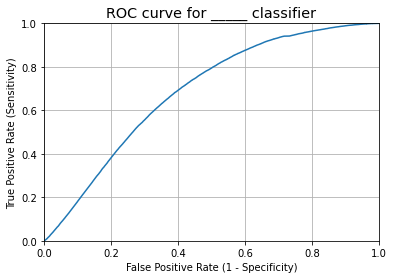

In [ ]:
 # ROC curve

# "y_test" should be the y(label) values in the testing sets, 
# a vector of 0s and 1s

# "y_pred_prob" is the stored predicted probabilities for class 1 
# Class 1 means true

fpr, tpr, thresholds = metrics.roc_curve(testy[:ntest], predIdxs[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for _____ classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(metrics.roc_auc_score(testy[:ntest], predIdxs[:,1])) # AUC score

In [ ]:
accuracy = accuracy_score(#test_generator.classes, #y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

## Learn Rate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from plot_conf_matr import plot_confusion_matrix

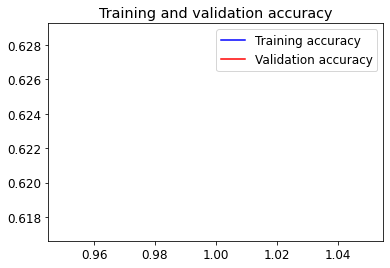

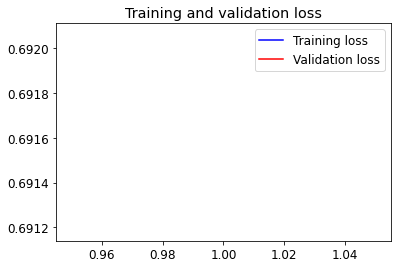

In [ ]:
# learning curves

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

## Precision and Recall

Logistic: f1=0.341 auc=0.221


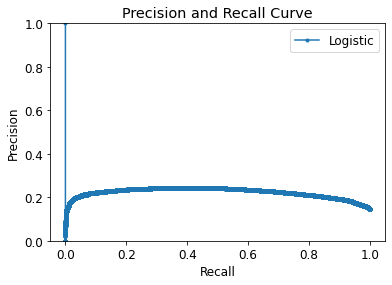

0.664665978057564


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(testy[:ntest], predIdxs[:,1])
lr_f1, lr_auc = f1_score(testy[:ntest], predIdxs2), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

pyplot.ylim([0.0, 1.0])
pyplot.title('Precision and Recall Curve')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print(metrics.recall_score(testy[:ntest], predIdxs2)) # Recall score